## Importando os pacotes a serem utilizados

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import HiveContext
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
#from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler,OneHotEncoder
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,OneHotEncoder
from pyspark.ml import Pipeline


### Inicio integração Hive

In [2]:
spark.sparkContext._conf.getAll()

[('spark.driver.port', '41155'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '10.30.30.21'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1559858245977'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'PySparkShell')]

In [3]:
conf = spark.sparkContext._conf.setAll([
    ("hive.metastore.uris", "thrift://localhost:9083")])

In [4]:
spark.stop()

In [5]:
sc = SparkContext()

In [6]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [7]:
spark.sparkContext._conf.getAll()

[('spark.driver.port', '41155'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '10.30.30.21'),
 ('hive.metastore.uris', 'thrift://localhost:9083'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1559858245977'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'PySparkShell')]

In [8]:
df = spark.sql("SHOW TABLES")
df.show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|     boosting_output|      false|
| default|        movieratings|      false|
| default|random_forest_output|      false|
+--------+--------------------+-----------+



### FIM integração Hive

In [12]:
# Importando a base do HDFS
#file_location = 'hdfs:///user/labdata/marketing/bank-additional-full.csv'
file_location = 'hdfs:///user/labdata/marketing_data'
file_type = "csv"

# schema CSV 
infer_schema = "true"
first_row_is_header = "false"
delimiter = ","

# As opções aplicadas são para arquivos CSV. Para outros tipos de arquivo, estes serão ignorados.
df_marketing_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)



In [13]:
# Inserindo cabeçalho (a tabela do Mysql está sem o cabeçalho)
DefColumnNames=df_marketing_data.schema.names
HeaderNames=['age','job','marital','education','default','housing','loan','contact','month','day_of_week','duration','campaign','pdays','previous','poutcome','emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed','y']

for Idx in range(0,21):
    df_marketing_data=df_marketing_data.withColumnRenamed(DefColumnNames[Idx],HeaderNames[Idx])
# Retirando a variável duration pois interfere na previsão do modelo
df_marketing_data = df_marketing_data.drop ('duration')

In [11]:
df_marketing_data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [14]:
# Definindo variáveis categóricas
categoricalColumns = []
numericCols = []
for i in df_marketing_data.dtypes:
    if i[1]=='string':
        categoricalColumns  += [i[0]]
    elif i[1]=='int' or i[1]=='double':
        numericCols  += [i[0]]

print(categoricalColumns)
print(numericCols)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
['age', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']


In [15]:
# Tratamento das colunas categóricas usando StringIndex / Encoder
stages = [] 
for categoricalCol in categoricalColumns:
  stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
  encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec")
  stages += [stringIndexer, encoder]
  
label_stringIdx = StringIndexer(inputCol = "y", outputCol = "label")
stages += [label_stringIdx]



In [16]:
## Assembler Inputs
assemblerInputs = ['jobclassVec', 'maritalclassVec', 'educationclassVec', 'defaultclassVec', 'housingclassVec', 'loanclassVec', 'contactclassVec', 'monthclassVec','poutcomeclassVec'] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [17]:
## PipeLine
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df_marketing_data)
df_marketing_data_prep = pipelineModel.transform(df_marketing_data)
df_marketing_data_prep.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- jobIndex: double (nullable = true)
 |-- jobclassVec: vector (nullable = true)
 |-- maritalIndex: double (nullable = true)
 |-- maritalclassVec: vector (nullable = true)
 |-- educationIndex: doub

In [18]:
df_marketing_data_prep.take(5)

[Row(age=56, job='housemaid', marital='married', education='basic.4y', default='no', housing='no', loan='no', contact='telephone', month='may', day_of_week='mon', campaign=1, pdays=999, previous=0, poutcome='nonexistent', emp_var_rate=1.1, cons_price_idx=93.994, cons_conf_idx=-36.4, euribor3m=4.857, nr_employed=5191.0, y='no', jobIndex=8.0, jobclassVec=SparseVector(11, {8: 1.0}), maritalIndex=0.0, maritalclassVec=SparseVector(3, {0: 1.0}), educationIndex=4.0, educationclassVec=SparseVector(7, {4: 1.0}), defaultIndex=0.0, defaultclassVec=SparseVector(2, {0: 1.0}), housingIndex=1.0, housingclassVec=SparseVector(2, {1: 1.0}), loanIndex=0.0, loanclassVec=SparseVector(2, {0: 1.0}), contactIndex=1.0, contactclassVec=SparseVector(1, {}), monthIndex=0.0, monthclassVec=SparseVector(9, {0: 1.0}), day_of_weekIndex=1.0, day_of_weekclassVec=SparseVector(4, {1: 1.0}), poutcomeIndex=0.0, poutcomeclassVec=SparseVector(2, {0: 1.0}), yIndex=0.0, yclassVec=SparseVector(1, {0: 1.0}), label=0.0, features=S

In [19]:
#Configurando o modelo para 100 iteracoes
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel
modelo = GBTClassifier(labelCol="label", featuresCol="features", maxIter=100)


In [20]:
# Divisão dos Dados de Teste e Treino
(marketing_model_treino, marketing_model_teste) = df_marketing_data_prep.randomSplit([0.7, 0.3])

In [21]:
# Preparando o Treino
modelo_treino = modelo.fit(marketing_model_treino)
modelo_treino.featureImportances

SparseVector(48, {0: 0.0168, 1: 0.0235, 2: 0.0173, 3: 0.0084, 4: 0.0104, 5: 0.0093, 6: 0.004, 7: 0.0094, 8: 0.0077, 9: 0.006, 10: 0.0124, 11: 0.0078, 12: 0.0119, 13: 0.0147, 14: 0.0122, 15: 0.016, 16: 0.0132, 17: 0.0177, 18: 0.0076, 19: 0.011, 20: 0.0116, 21: 0.0141, 23: 0.0055, 24: 0.0075, 25: 0.011, 26: 0.0116, 27: 0.0253, 28: 0.0101, 29: 0.0064, 30: 0.004, 31: 0.0047, 32: 0.0126, 33: 0.0083, 34: 0.0061, 35: 0.0024, 36: 0.0064, 37: 0.0026, 38: 0.0147, 39: 0.1523, 40: 0.0881, 41: 0.0489, 42: 0.0314, 43: 0.0527, 44: 0.0324, 45: 0.0531, 46: 0.1129, 47: 0.0261})

In [22]:
# Salvando o modelo no HDFS
hdfs_path = "/user/labdata/modelo_BST2"
modelo_treino.write().overwrite().save(hdfs_path)

In [23]:
modelo_treino2 =GBTClassificationModel.load(hdfs_path)

In [24]:
# Predição do modelo
predict = modelo_treino2.transform(marketing_model_treino)

In [25]:
predict.select("features").take(5)

[Row(features=SparseVector(48, {10: 1.0, 12: 1.0, 16: 1.0, 21: 1.0, 27: 1.0, 30: 1.0, 38: 1.0, 39: 17.0, 40: 2.0, 41: 999.0, 42: 1.0, 43: -2.9, 44: 92.201, 45: -31.4, 46: 0.869, 47: 5076.2})),
 Row(features=SparseVector(48, {10: 1.0, 12: 1.0, 16: 1.0, 21: 1.0, 23: 1.0, 25: 1.0, 27: 1.0, 30: 1.0, 38: 1.0, 39: 17.0, 40: 2.0, 41: 999.0, 42: 2.0, 43: -2.9, 44: 92.201, 45: -31.4, 46: 0.869, 47: 5076.2})),
 Row(features=SparseVector(48, {10: 1.0, 12: 1.0, 18: 1.0, 21: 1.0, 23: 1.0, 26: 1.0, 27: 1.0, 33: 1.0, 37: 1.0, 39: 18.0, 40: 2.0, 41: 999.0, 43: -1.8, 44: 93.075, 45: -47.1, 46: 1.365, 47: 5099.1})),
 Row(features=SparseVector(48, {10: 1.0, 12: 1.0, 19: 1.0, 21: 1.0, 23: 1.0, 25: 1.0, 27: 1.0, 30: 1.0, 37: 1.0, 39: 18.0, 40: 1.0, 41: 999.0, 43: -2.9, 44: 92.201, 45: -31.4, 46: 0.861, 47: 5076.2})),
 Row(features=SparseVector(48, {10: 1.0, 12: 1.0, 15: 1.0, 21: 1.0, 24: 1.0, 25: 1.0, 27: 1.0, 28: 1.0, 38: 1.0, 39: 18.0, 40: 1.0, 41: 999.0, 42: 1.0, 43: -1.8, 44: 92.893, 45: -46.2, 46: 1.2

In [26]:
predict.show()

+---+-------+-------+-----------+-------+-------+-------+---------+-----+-----------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+--------+---------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+------------+---------------+----------+-------------+----------------+-------------------+-------------+----------------+------+-------------+-----+--------------------+--------------------+--------------------+----------+
|age|    job|marital|  education|default|housing|   loan|  contact|month|day_of_week|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|jobIndex|    jobclassVec|maritalIndex|maritalclassVec|educationIndex|educationclassVec|defaultIndex|defaultclassVec|housingIndex|housingclassVec|loanIndex| loanclassVec|contactIndex|contactclassVec|monthIndex|monthclassVec|day_of

In [27]:
results = predict.select(['probability', 'label'])

In [28]:
# Salvando modelo no Hive
import pyspark
df_writer = pyspark.sql.DataFrameWriter(predict)
df_writer.saveAsTable('default.boosting_output', format='parquet', mode='overwrite')

In [29]:
#
spark.sql("SELECT * FROM default.boosting_output").show()

+---+-------+-------+-----------+-------+-------+-------+---------+-----+-----------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+--------+---------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+------------+---------------+----------+-------------+----------------+-------------------+-------------+----------------+------+-------------+-----+--------------------+--------------------+--------------------+----------+
|age|    job|marital|  education|default|housing|   loan|  contact|month|day_of_week|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|jobIndex|    jobclassVec|maritalIndex|maritalclassVec|educationIndex|educationclassVec|defaultIndex|defaultclassVec|housingIndex|housingclassVec|loanIndex| loanclassVec|contactIndex|contactclassVec|monthIndex|monthclassVec|day_of

In [30]:
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

In [31]:
metrics = metric(scoreAndLabels)
print("The ROC score is (@maxIter=100): ", metrics.areaUnderROC)

The ROC score is (@maxIter=100):  0.8417852162931738


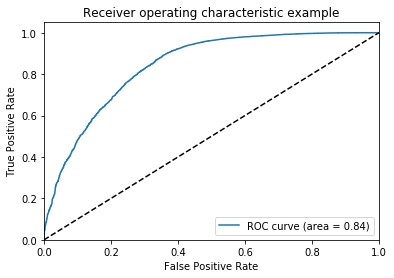

In [32]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
get_ipython().run_line_magic('matplotlib', 'inline')
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
display()